In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import scipy.io
import shutil
import json

from patches import Patches, PatchEncoder
from hyperparameters import *
from tools import *

In [2]:
# Load configuration
if os.path.exists('config/localconfig.py'):
    from config import localconfig as config
else:
    from config import config

In [3]:
image_paths = [
    f for f in os.listdir(config.BB_IMAGES) if os.path.isfile(os.path.join(config.BB_IMAGES, f))
]

import random
random.shuffle(image_paths)
annot_paths = [f'{i}.json' for i in image_paths]

images, targets = [], []

In [4]:
with open(os.path.join(config.BB_ANNOTATIONS, annot_paths[180])) as f:
    annot = json.load(f)

annot

{'description': '',
 'tags': [{'id': 118617921,
   'tagId': 30143178,
   'name': 'train',
   'value': None,
   'labelerLogin': 'vniclas',
   'createdAt': '2021-01-31T11:35:00.548Z',
   'updatedAt': '2021-01-31T11:35:00.548Z'}],
 'size': {'height': 920, 'width': 2872},
 'objects': [{'id': 890027983,
   'classId': 9993506,
   'description': '',
   'geometryType': 'rectangle',
   'labelerLogin': 'vniclas',
   'createdAt': '2021-01-31T11:22:48.089Z',
   'updatedAt': '2021-01-31T11:22:48.089Z',
   'tags': [{'id': 135984472,
     'tagId': 30143181,
     'name': 'sticker_band_removed',
     'value': None,
     'labelerLogin': 'vniclas',
     'createdAt': '2021-01-31T11:22:48.089Z',
     'updatedAt': '2021-01-31T11:22:48.089Z'}],
   'classTitle': 'yellow_cone',
   'points': {'exterior': [[1058, 298], [1106, 361]], 'interior': []}},
  {'id': 890027982,
   'classId': 9993511,
   'description': '',
   'geometryType': 'rectangle',
   'labelerLogin': 'vniclas',
   'createdAt': '2021-01-31T11:22:48.

In [5]:
for i in range(0, 2000):
    image = keras.utils.load_img(os.path.join(config.BB_IMAGES, image_paths[i]))

    w, h = image.size[:2]

    # resize training set
    if i < int(len(annot_paths) * 0.8):
        image = image.resize((image_size, image_size))
    images.append(keras.utils.img_to_array(image))

    with open(os.path.join(config.BB_ANNOTATIONS, annot_paths[i])) as f:
        annot = json.load(f)

    target = []
    for a in annot['objects']:
        coords = a['points']['exterior']
        top_left_x, top_left_y = coords[0][0], coords[0][1]
        bottom_right_x, bottom_right_y = coords[1][0], coords[1][1]
        target.append((float(top_left_x) / w,
                       float(top_left_y) / h,
                       float(bottom_right_x) / w,
                       float(bottom_right_y) / h))

    if len(target) > 0:
        targets.append(target[0])
    else:
        images.pop()

In [6]:
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

In [7]:
num_classes = 5

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (1600, 224, 224, 3) - y_train shape: (1600, 4)
x_test shape: (400, 224, 224, 3) - y_test shape: (400, 4)


Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


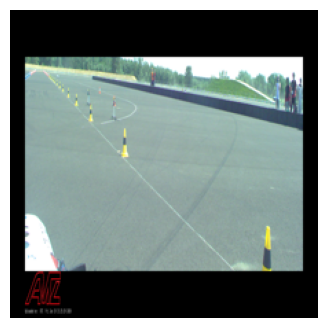

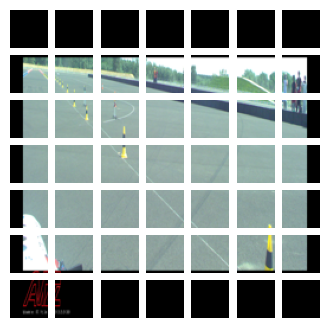

In [8]:
plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [10]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history

In [11]:
history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
45/45 [==============================] - 7s 59ms/step - loss: 0.3663 - val_loss: 0.1568
Epoch 2/100
45/45 [==============================] - 2s 40ms/step - loss: 0.1306 - val_loss: 0.0588
Epoch 3/100
45/45 [==============================] - 2s 38ms/step - loss: 0.0713 - val_loss: 0.0452
Epoch 4/100
45/45 [==============================] - 2s 37ms/step - loss: 0.0612 - val_loss: 0.0411
Epoch 5/100
45/45 [==============================] - 1s 28ms/step - loss: 0.0537 - val_loss: 0.0439
Epoch 6/100
45/45 [==============================] - 2s 38ms/step - loss: 0.0538 - val_loss: 0.0408
Epoch 7/100
45/45 [==============================] - 1s 29ms/step - loss: 0.0526 - val_loss: 0.0413
Epoch 8/100
45/45 [==============================] - 1s 30ms/step - loss: 0.0497 - val_loss: 0.0432
Epoch 9/100
45/45 [==============================] - 1s 30ms/step - loss: 0.0489 - val_loss: 0.0418
Epoch 10/100
45/45 [==============================] - 1s 30ms/step - loss: 0.0486 - val_loss: 0.0419

1/1 [==============================] - 0s 29ms/step
mean_iou: 0.02142857142857143


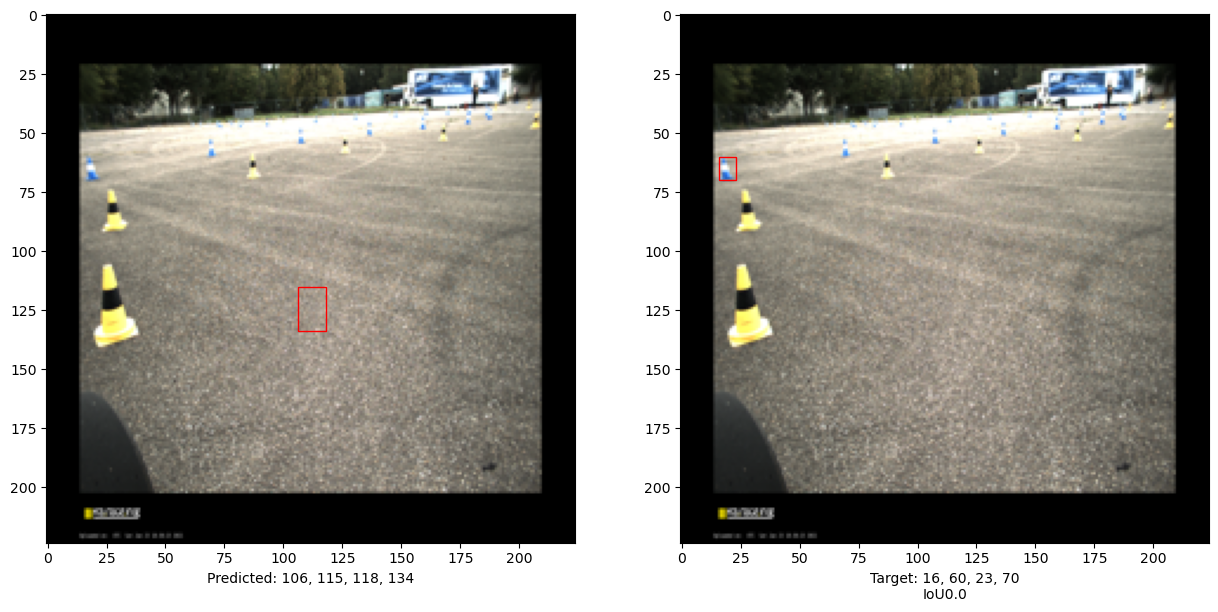

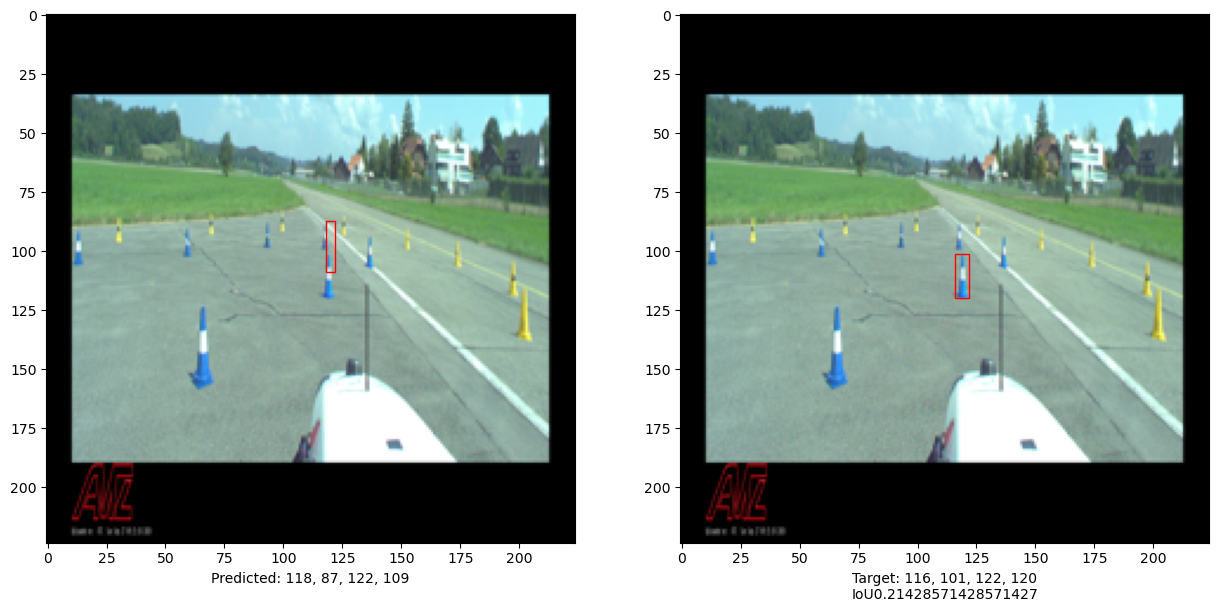

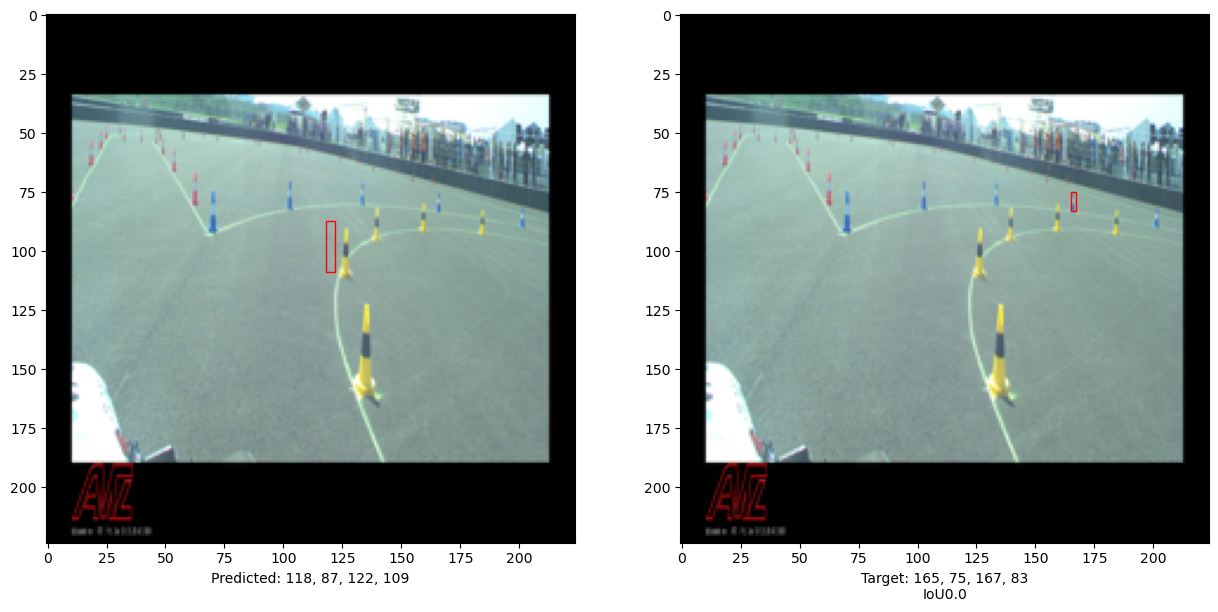

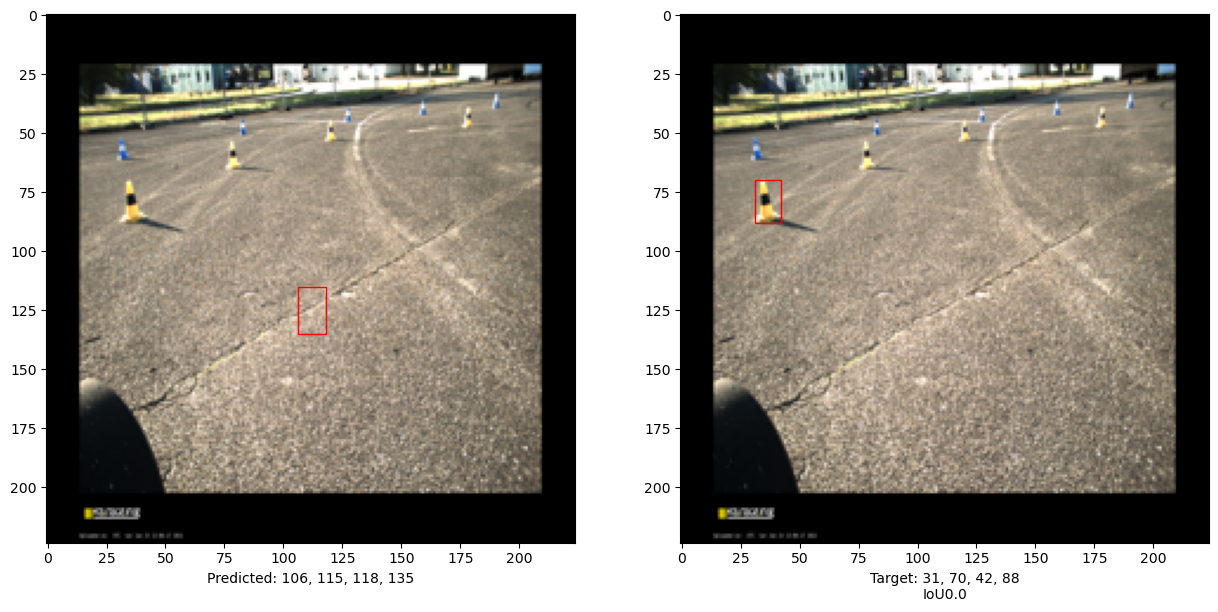

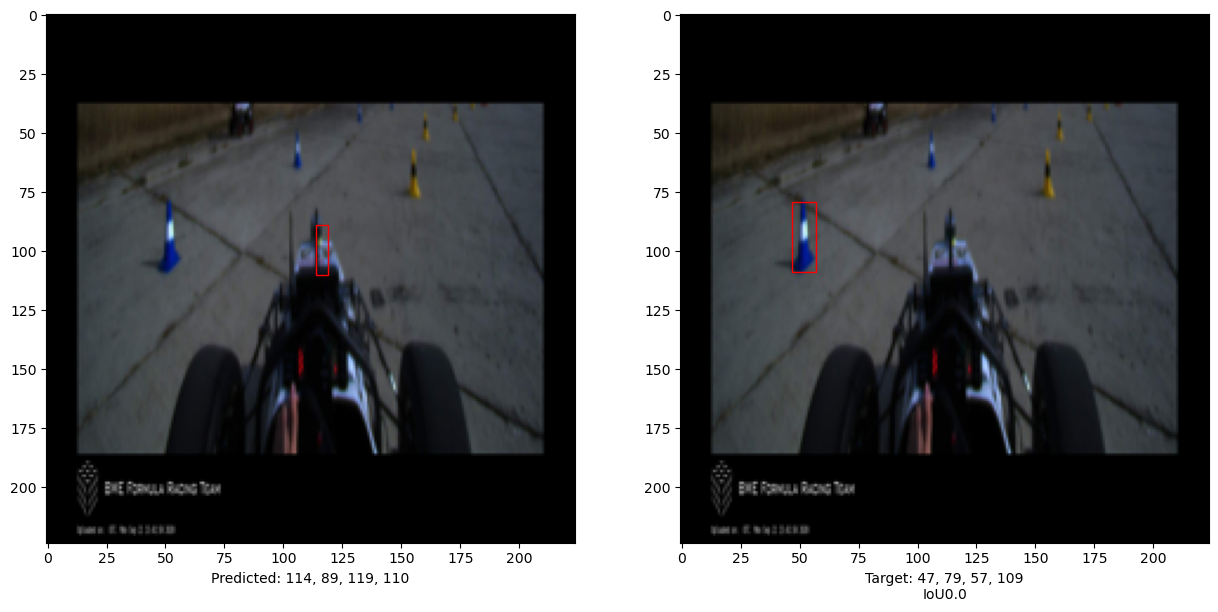

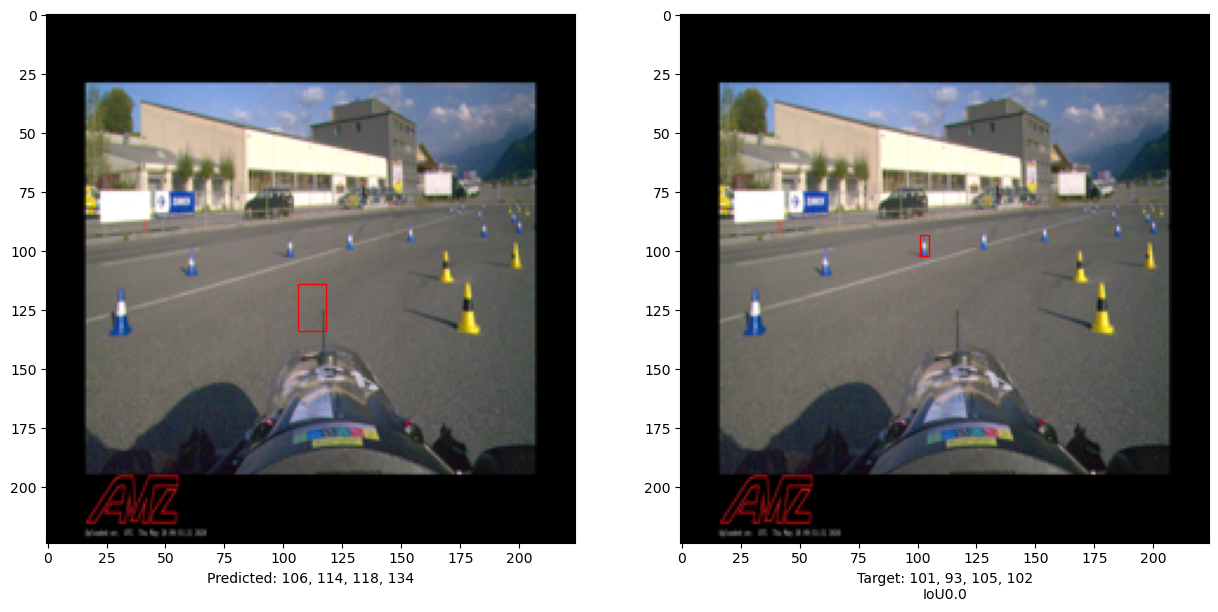

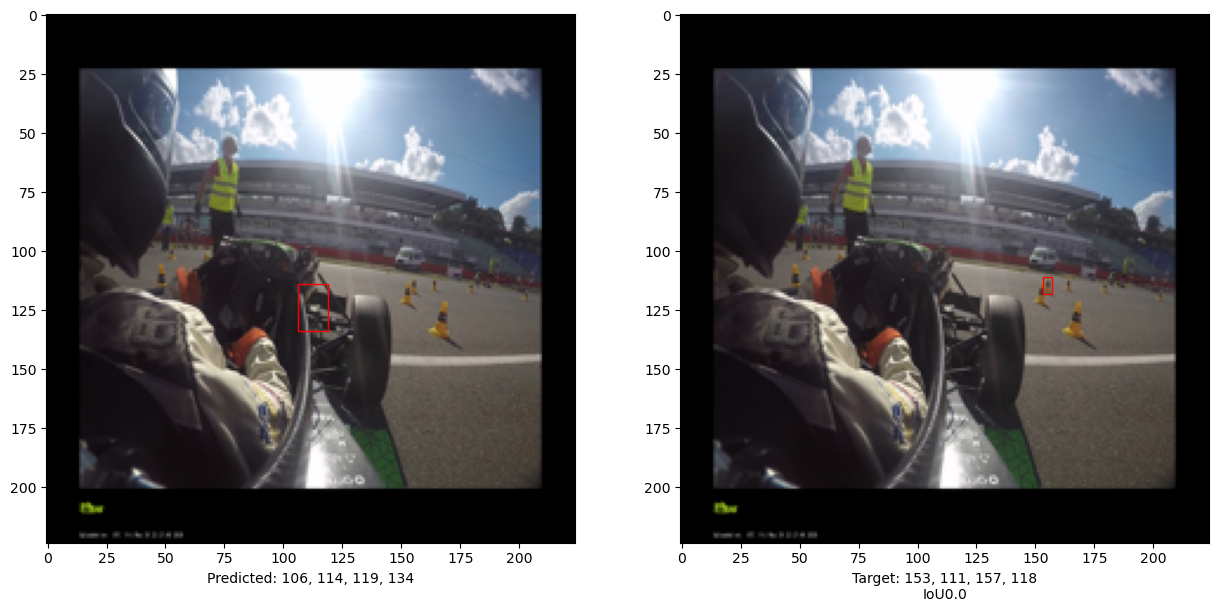

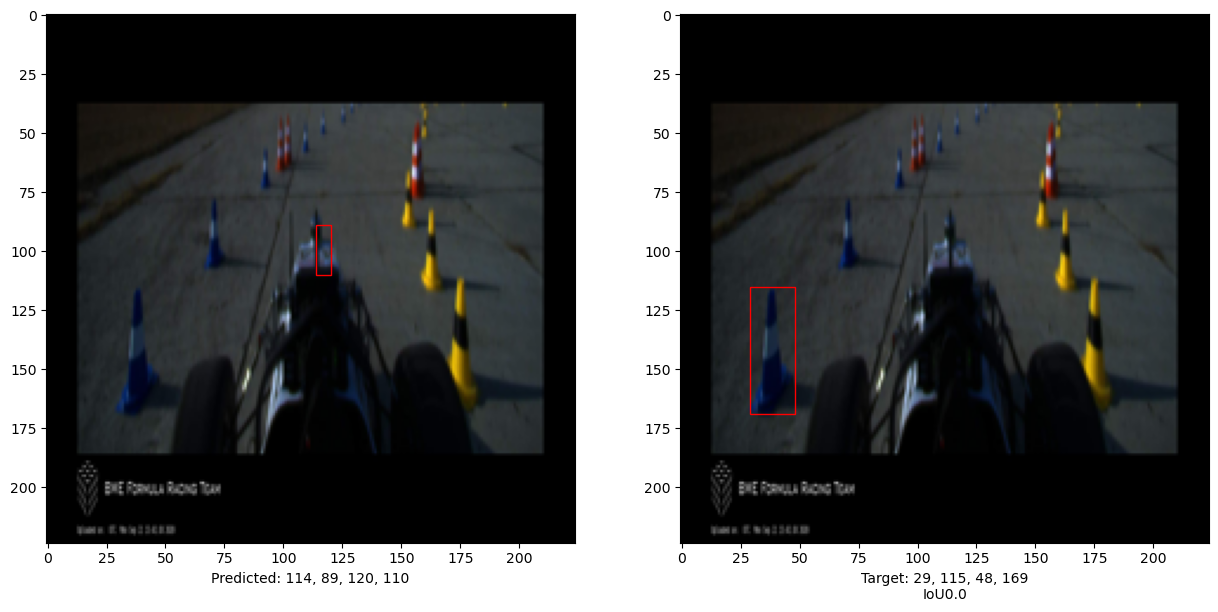

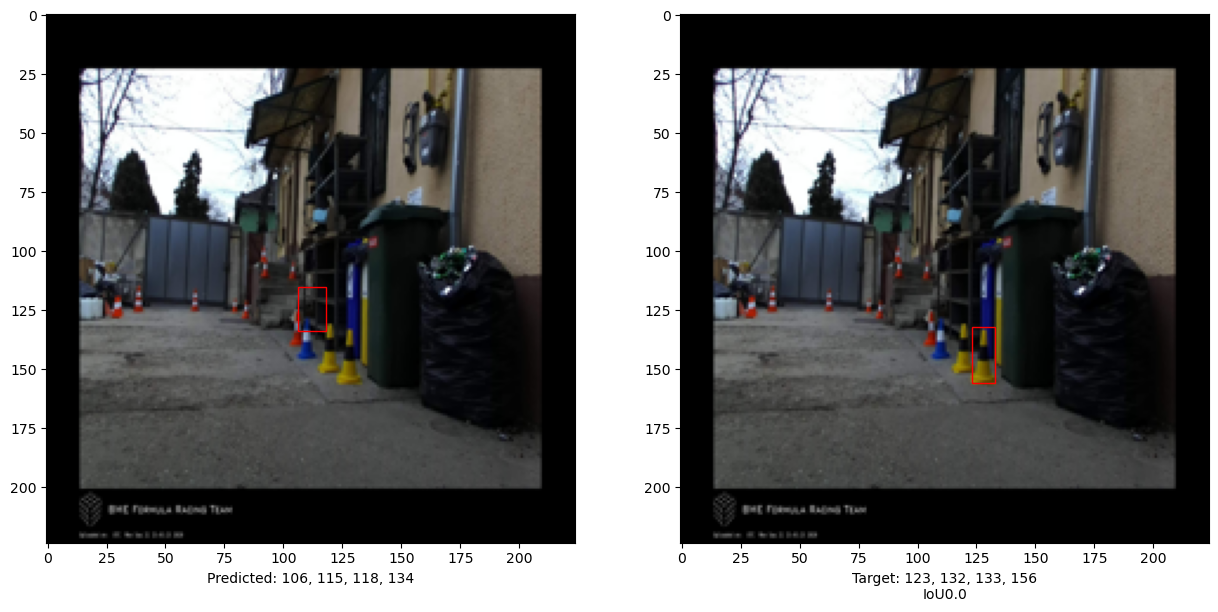

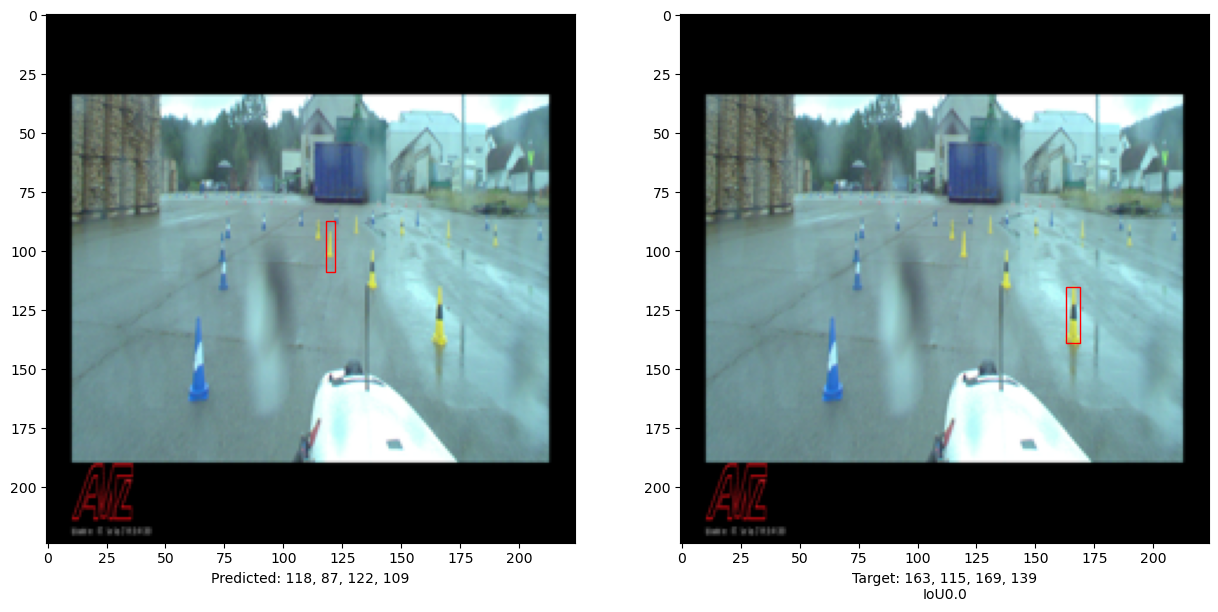

In [12]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()